In [2]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Loading the Dataset  

In [3]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [4]:
df = pd.read_csv("Preprocessed Fake Reviews Detection Dataset.csv")

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.dropna(inplace=True)

# Displaying the contents of the Dataset 

In [6]:
df.head()


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


# Add the Review length as one field

In [7]:
df['length'] = df['text_'].apply(len)
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [8]:
df.head()

,category,rating,label,text_,length,target
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti,48,0
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year,46,0
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow,44,0
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i,37,0
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month,43,0


# Statistics about the length of the review

/home/u188274/tmp/ipykernel_2806628/120245119.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=df["length"], kde=False, bins=[0,10,25,50,75,100,125,150,175,200,225,250,275,300,325,350])


Text(0, 0.5, 'Number of Reviews')

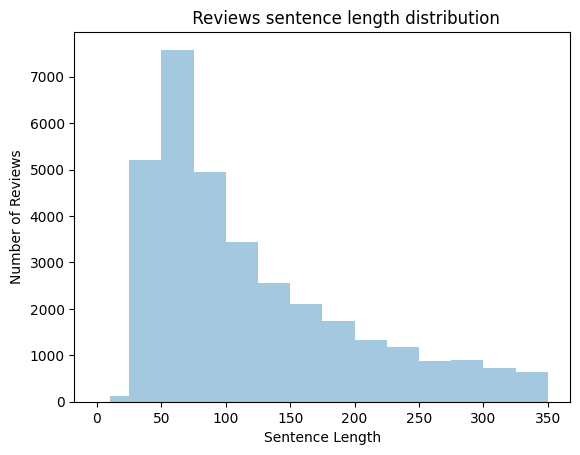

In [9]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(a=df["length"], kde=False, bins=[0,10,25,50,75,100,125,150,175,200,225,250,275,300,325,350])
plt.title("         Reviews sentence length distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Reviews")

# Statistics about the Category Labels

Text(0.5, 1.0, '        Review counts by categories')

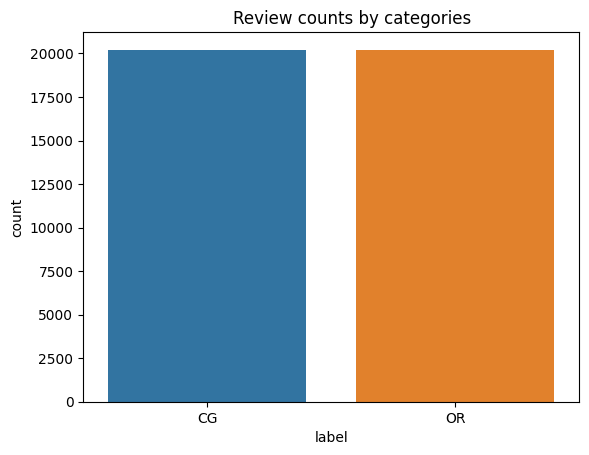

In [10]:
sns.countplot(data=df, x="label")
plt.title("        Review counts by categories")


# Statistics about the Category Types

Text(0.5, 1.0, '        Review counts by categories')

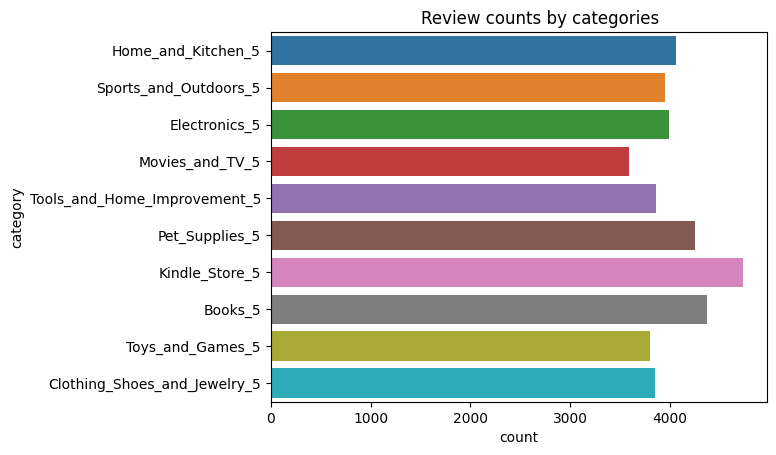

In [11]:
sns.countplot(data=df, y="category")
plt.title("        Review counts by categories")

# ** Splitting the train and test dataset **


In [12]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)


In [13]:
len(train),len(test)

(32344, 8087)

In [14]:
COMMENT = 'text_'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

#  ** Tokenize the String **

In [15]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# ** TFIDFVecotorizer - feature extraction - converts the strings to numbers for processing  

In [16]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

/home/u188274/.local/lib/python3.9/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/home/u188274/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/u188274/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1682: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [17]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [18]:
x = trn_term_doc
test_x = test_term_doc

# ** Multinomial Naive Bayes -- Patch Sklearn extension - makes the intel optimization  

In [34]:
from sklearn.pipeline import Pipeline

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    #('bow',CountVectorizer(analyzer=text_process)),
    #('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

import time

start_time = time.time()
pipeline.fit(trn_term_doc,train["target"])
predictions = pipeline.predict(test_term_doc)
patched_time = time.time() - start_time
print("Time to calculate Multinomial Naive Bayes Algorithm Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))
predictions

print('Classification Report:',classification_report(test["target"],predictions))
print('Confusion Matrix:',confusion_matrix(test["target"],predictions))
print('Accuracy Score:',accuracy_score(test["target"],predictions))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(test["target"],predictions)*100,2)) + '%')

Time to calculate Multinomial Naive Bayes Algorithm Patched scikit-learn  0.0 seconds
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3998
           1       0.92      0.88      0.90      4089

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

Confusion Matrix: [[3683  315]
 [ 480 3609]]
Accuracy Score: 0.901694076913565
Model Prediction Accuracy: 90.17%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# ** Random Forest -- Patch Sklearn extension - makes the intel optimization  

In [39]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    #('bow',CountVectorizer(analyzer=text_process)),
    #('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])
start_time = time.time()
pipeline.fit(trn_term_doc,train["target"])
rfc_pred = pipeline.predict(test_term_doc)
patched_time = time.time() - start_time
print("Time to calculate Random Forest Algorithm Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))
rfc_pred
print('Classification Report:',classification_report(test["target"],rfc_pred))
print('Confusion Matrix:',confusion_matrix(test["target"],rfc_pred))
print('Accuracy Score:',accuracy_score(test["target"],rfc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(test["target"],rfc_pred)*100,2)) + '%')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/u188274/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Time to calculate Random Forest Algorithm Patched scikit-learn 68.5 seconds
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3998
           1       0.89      0.91      0.90      4089

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087

Confusion Matrix: [[3522  476]
 [ 386 3703]]
Accuracy Score: 0.893409175219488
Model Prediction Accuracy: 89.34%


# ** Random Forest -- unpatch Sklearn extension - without intel optimization  

In [37]:
from sklearnex import patch_sklearn, unpatch_sklearn
unpatch_sklearn()

from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    #('bow',CountVectorizer(analyzer=text_process)),
    #('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])
start_time = time.time()
pipeline.fit(trn_term_doc,train["target"])
rfc_pred = pipeline.predict(test_term_doc)
patched_time = time.time() - start_time
print("Time to calculate Random Forest Algorithm Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))
rfc_pred
print('Classification Report:',classification_report(test["target"],rfc_pred))
print('Confusion Matrix:',confusion_matrix(test["target"],rfc_pred))
print('Accuracy Score:',accuracy_score(test["target"],rfc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(test["target"],rfc_pred)*100,2)) + '%')

Time to calculate Random Forest Algorithm Patched scikit-learn 69.1 seconds
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3998
           1       0.88      0.91      0.89      4089

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087

Confusion Matrix: [[3504  494]
 [ 384 3705]]
Accuracy Score: 0.8914306912328428
Model Prediction Accuracy: 89.14%


# ** XGBoost Classifier -- patch Sklearn extension - with intel optimization  

In [43]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
from xgboost import XGBClassifier
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

pipeline = Pipeline([
    #('bow',CountVectorizer(analyzer=text_process)),
    #('tfidf',TfidfTransformer()),
    ('classifier',clf)
])

import time
start_time = time.time()
pipeline.fit(trn_term_doc,train["target"])
xgb_pred = pipeline.predict(test_term_doc)
patched_time = time.time() - start_time
print("Time to calculate Using XGBoost Regression {:4.1f}\033[0m seconds".format(patched_time))

xgb_pred

print('Classification Report:',classification_report(test["target"],xgb_pred))
print('Confusion Matrix:',confusion_matrix(test["target"],xgb_pred))
print('Accuracy Score:',accuracy_score(test["target"],xgb_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(test["target"],xgb_pred)*100,2)) + '%')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Time to calculate Using XGBoost Regression  4.3 seconds
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3998
           1       0.88      0.89      0.88      4089

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087

Confusion Matrix: [[3488  510]
 [ 444 3645]]
Accuracy Score: 0.882032892296278
Model Prediction Accuracy: 88.2%


# ** Logistic Regression -- patch Sklearn extension - with intel optimization  

In [45]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4,max_iter=1000)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
from sklearn.linear_model import LogisticRegression


start_time = time.time()
m,r = get_mdl(train["target"])
preds_probas = m.predict_proba(test_x.multiply(r))[:,1]
patched_time = time.time() - start_time
print("Time to calculate Using Logistic Regression {:4.1f}\033[0m seconds".format(patched_time))

preds = [1 if prob>=0.5 else 0 for prob in preds_probas]

from sklearn.metrics import confusion_matrix
y_true = test.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Time to calculate Using Logistic Regression  2.7 seconds


In [46]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}") #with patch

Accuracy: 92.8156300234945; Precision:91.46572104018912; Recall:94.6197114208853


# ** Gradient Boosting Classifier -- patch Sklearn extension - with intel optimization  

In [22]:
#Training
from sklearn.pipeline import Pipeline

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    #('bow',CountVectorizer(analyzer=text_process)),
    #('tfidf',TfidfTransformer()),
    ('classifier',GradientBoostingClassifier())
])

import time
start_time = time.time()
pipeline.fit(trn_term_doc,train["target"])
xgb_pred = pipeline.predict(test_term_doc)
patched_time = time.time() - start_time
print("Time to calculate Using GradientBoostingClassifier  {:4.1f}\033[0m seconds".format(patched_time))

xgb_pred

print('Classification Report:',classification_report(test["target"],xgb_pred))
print('Confusion Matrix:',confusion_matrix(test["target"],xgb_pred))
print('Accuracy Score:',accuracy_score(test["target"],xgb_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(test["target"],xgb_pred)*100,2)) + '%')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Time to calculate Using GradientBoostingClassifier  47.4 seconds
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.80      0.81      3998
           1       0.81      0.84      0.83      4089

    accuracy                           0.82      8087
   macro avg       0.82      0.82      0.82      8087
weighted avg       0.82      0.82      0.82      8087

Confusion Matrix: [[3190  808]
 [ 642 3447]]
Accuracy Score: 0.8206998887102758
Model Prediction Accuracy: 82.07000000000001%
